In [1]:
import keras
import numpy as np
from neuralStellar2 import stellarGrid,NNmodel
import pymc3 as pm
import theano.tensor as T
import corner
import pandas as pd

Using TensorFlow backend.


In [2]:
m1=NNmodel('evo',['mass','age','feh','MLT'],['L','Teff','delnu'])
m1.loadModel('Ran_files/big_grid_12/000_best_model.h5')
#m1.loadModel('MGM_test.h5')
#m1.loadModel('SGM_lrtest.h5')

Model: "interstellar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 5)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [28]:
Msun=1.2
Agesun=4.6
Fehsun=0
Ysun=0.28
MLTsun=1.9
print('R/Rsun', 'Teff', 'delta nu', '=')
y_out = m1.model.predict(np.log10([[Msun,Agesun,10**Fehsun,Ysun,MLTsun]])).T
print(10**y_out)
Lsun = (10**y_out[0])**2*(10**y_out[1]*5000/5942.261537)**4
print('L/Lsun = '+str(Lsun))
#1, 5777, 135

R/Rsun Teff delta nu =
[[ 2.3466818]
 [ 1.1520443]
 [44.7646   ]]
L/Lsun = [4.862483]


Inputs:
M=N(1,0.1)<br>
Age=N(4.5,0.5)<br>
feh=N(0,0.1)<br>
MLT=N(1.9,0.1)<br>
<br>
Outputs(obs):<br>
L=N(1,0.1)<br>
Teff=N(5777,70)<br>
delnu=N(135,15)<br>

In [35]:
m1.getWeights()

model = pm.Model()
with model:
    M = pm.Deterministic('mass',pm.Beta('a',1.5,1.5)*(2*0.2)+(1.2-0.2))
    Age = pm.Deterministic('age',pm.Beta('b',1.5,1.5)*(2*0.5)+(4.6-0.5))
    feh = pm.Deterministic('feh',pm.Beta('c',1.1,1.1)*(2*0.1)+(0-0.1))
    Y = pm.Deterministic('Y',pm.Beta('d',1.1,1.1)*(2*0.03)+(0.28-0.03))
    MLT = pm.Deterministic('MLT',pm.Beta('e',1.1,1.1)*(2*0.1)+(1.9-0.1))
    
    obs = pm.Deterministic('obs',m1.manualPredict(T.log10([M, Age, 10**feh, Y, MLT])))
    
    #obs data from NN generated
    obs_L = pm.Normal('obs_L',(10**obs[0])**2*(10**obs[1]*5000/5942.261537)**4,0.1, observed=4.862483)
    obs_Teff = pm.Normal('obs_Teff',10**obs[1]*5000,70, observed=1.1520443*5000)
    obs_delnu = pm.Normal('obs_delnu',10**obs[2],0.1, observed=44.7646)

In [36]:
#start = {'mass': 0.8, 'age': 2.5, 'feh':0.1, 'MLT':1.8}
start = {'mass': 1.0, 'age': 4.6}
with model:
    trace = pm.sample(tune=5000, target_accept = 0.99, start=start, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [e, d, c, b, a]


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [37]:
pm.summary(trace, var_names=['mass','age','feh','Y','MLT'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mass,1.169,0.026,1.127,1.222,0.004,0.003,47.0,47.0,49.0,66.0,1.01
age,4.593,0.148,4.343,4.878,0.026,0.019,31.0,31.0,30.0,101.0,1.05
feh,-0.051,0.030,-0.095,0.003,0.005,0.003,42.0,41.0,44.0,238.0,1.07
Y,0.287,0.013,0.265,0.310,0.002,0.002,34.0,33.0,30.0,51.0,1.04
MLT,1.929,0.048,1.839,2.000,0.011,0.008,21.0,20.0,26.0,98.0,1.09


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BD70F7FC88>,
      dtype=object)

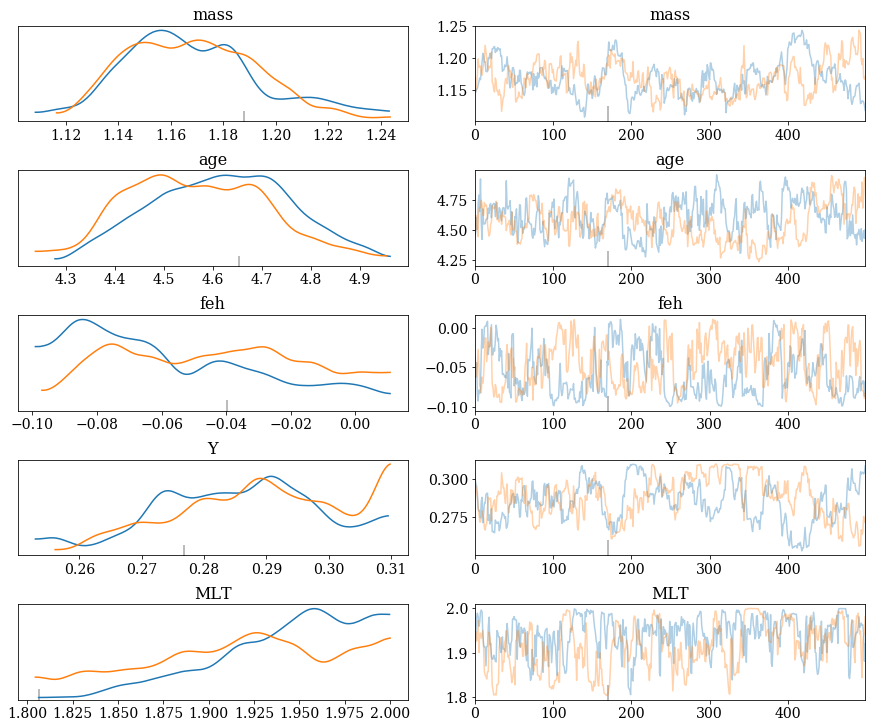

In [38]:
pm.plots.traceplot(trace, var_names=['mass','age','feh','Y','MLT'])

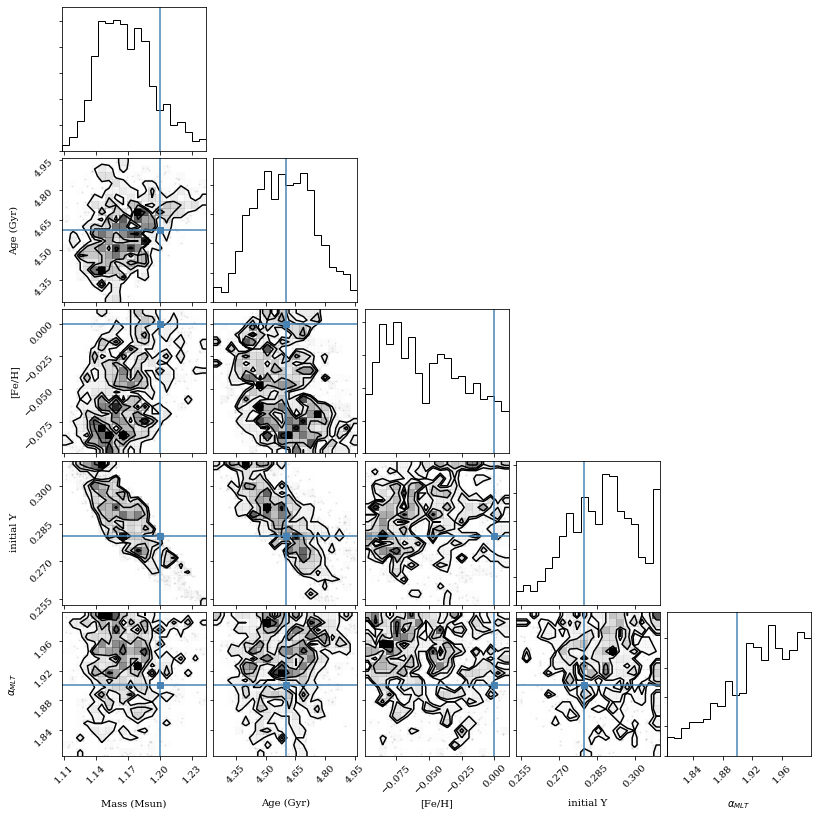

In [39]:
#corner.corner(np.array([trace['mass'], trace['age'], trace['feh'], trace['MLT']]).T, truths=[1.0, 4.5, 0, 1.9],
#             labels=['Mass', 'Age', 'Fe/H', 'Alpha_MLT']);
corner.corner(np.array([trace['mass'], trace['age'], trace['feh'], trace['Y'], trace['MLT']]).T, truths=[1.2,4.6,0,0.28,1.9], labels=['Mass (Msun)','Age (Gyr)','[Fe/H]','initial Y',r'$\alpha_{MLT}$']);

In [80]:
true_M=1
true_age = 4.577450829
print('error (dex) on mass = ',abs((np.mean(trace['mass'])-true_M)/true_M))
print('error (dex) on age = ',abs((np.mean(trace['age'])-true_age)/true_age))

error (dex) on mass =  0.0013274694638958362
error (dex) on age =  0.016569595239434357


In [4]:
T.ones(5).eval()

array([1., 1., 1., 1., 1.])

In [12]:
grid1 = pd.read_csv('grid2_trun.csv')
grid1 = grid1[grid1['initial_feh']==0]

,Unnamed: 0,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,star_mass,star_age,effective_T,luminosity,radius,star_feh,delta_nu,nu_max,tenfeh,tenstarfeh
0,3300910,2,1.28,0.30,0.0,1.7,1.260435,3.662295,4164.398110,118.256239,20.920227,1.376922e-02,1.722789,10.515367,1.0,1.032213
13,7866165,2,1.76,0.30,0.0,2.1,1.753560,1.226000,4723.251740,90.496281,14.226302,1.027665e-02,3.559745,29.704955,1.0,1.023945
15,4936982,2,1.48,0.30,0.0,1.7,1.476795,2.113251,4801.731744,15.323097,5.664171,1.029131e-02,12.933392,156.516994,1.0,1.023980
23,6218481,2,1.64,0.28,0.0,1.9,1.634233,1.762542,4670.197840,50.941674,10.917542,1.178606e-02,5.095554,47.272593,1.0,1.027510
26,3782324,2,1.32,0.28,0.0,2.1,1.313855,3.700863,4835.011599,28.579624,7.629429,1.429926e-02,7.808458,76.485203,1.0,1.033473
33,8643483,2,1.88,0.30,0.0,1.9,1.868154,1.004764,4394.333325,182.351517,23.330687,9.894822e-03,1.769534,12.198995,1.0,1.023045
36,1863702,2,1.08,0.30,0.0,1.9,1.063457,6.664205,4401.491645,67.658969,14.165169,1.529846e-02,2.816597,18.823022,1.0,1.035854
40,9578274,2,1.96,0.26,0.0,2.3,1.958622,1.065937,5199.911572,21.906704,5.775046,6.053234e-03,14.453584,191.891044,1.0,1.014036
42,5141099,2,1.40,0.28,0.0,1.7,1.396953,2.884295,4838.938038,8.714488,4.206100,6.809317e-03,19.668354,267.460949,1.0,1.015803
44,6516993,2,1.68,0.26,0.0,1.9,1.676983,1.802655,4862.294883,21.843439,6.595333,1.136146e-02,10.954879,130.270913,1.0,1.026506


In [18]:
grid1 = grid1[grid1['initial_Yinit']==0.28]
grid1 = grid1[grid1['initial_mass']==1]
grid1 = grid1[grid1['initial_MLT']==1.9]
grid1 = grid1[grid1['star_age'].between(4.5,4.7)]

In [19]:
grid1

,Unnamed: 0,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,star_mass,star_age,effective_T,luminosity,radius,star_feh,delta_nu,nu_max,tenfeh,tenstarfeh
149233,2027292,1,1.0,0.28,0.0,1.9,1.0,4.574027,5942.261537,1.301724,1.077990,1.590387e-09,126.379732,2630.312959,1.0,1.0
356986,2027293,1,1.0,0.28,0.0,1.9,1.0,4.664695,5943.618183,1.313908,1.082529,1.590890e-09,125.608554,2608.005092,1.0,1.0


In [ ]:
    obs_L = pm.Normal('obs_L',(10**obs[0])**2*(10**obs[1]*5000/5942.261537)**4,0.1, observed=1.301724)
    obs_Teff = pm.Normal('obs_Teff',10**obs[1]*5000,70, observed=5942.261537)
    obs_delnu = pm.Normal('obs_delnu',10**obs[2],0.1, observed=126.379732)